# <font color='blue'>Projeto Análise de Market Basket Analysis com Linguagem Python</font>
### <font color='blue'>Análise descritiva com algoritmo de Mineração de dados  </font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.10.9


### <font color='blue'>Importando as bibliotecas </font>

In [2]:
# Bibliotecas de manipulação de dados 
import pandas as pd
import numpy as np
# Bibliotecas para plotagem 
import matplotlib.pyplot as plt
import seaborn as sn
# Biblioteca de manipulação de data 
from datetime import datetime
# Pacote para combinar dados 
from itertools import combinations
# Pacote para implementar o algoritmo apriori
import efficient_apriori
from efficient_apriori import apriori

### <font color='blue'>Carregando os dados</font>

In [3]:
# Importando nossos arquivos csv
aisle = pd.read_csv('aisles.csv')
department = pd.read_csv('departments.csv')
order = pd.read_csv('orders.csv')
product = pd.read_csv('products.csv')
order_product_prior = pd.read_csv('order_products__prior.csv')
order_product_train = pd.read_csv('order_products__train.csv')

### <font color='blue'>Análise Exploratória</font>

In [4]:
aisle.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
department.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
# Visualizando a "Calda" do meu conjunto de dados
order.tail()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0
3421082,272231,206209,train,14,6,14,30.0


In [8]:
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
order_product_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:
order_product_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [11]:
# Verificando o numero de todos os registros de todos os nossos datasets
count_array = np.array([['Aisles', len(aisle)],
                        ['Department', len(department)],
                        ['Product', len(product)],
                        ['Order', len(order)],
                        ['Order_Product_Prior', len(order_product_prior)],
                        ['Order_Product_Train', len(order_product_train)]])
count_record = pd.DataFrame(count_array, columns = ['Arquivo', 'Total de Registros'])
count_record

,Arquivo,Total de Registros
0,Aisles,134
1,Department,21
2,Product,49688
3,Order,3421083
4,Order_Product_Prior,32434489
5,Order_Product_Train,1384617


* Vimos que a empresa possui um conjunto de dados relativamente grande para a análise, e que a empresa estar divida em departamentos e em cada departamento temos corredores de produtos.
* Vimos também que foram coletados dados sobre pedidos anteriores dos meus clientes e encomendas

## <font color='blue'>Limpeza de dados </font>

## 1-Tratar valores ausentes

In [12]:
# Criando uma fuction para identificar o percentual de valores ausentes 
# Calcula o percentual de valores ausentes
def func_calc_percentual_valores_ausentes(df):
    totalCells = np.product(df.shape)
    missingCount = df.isnull().sum()
    totalMissing = missingCount.sum()
    print("O dataset tem", round(((totalMissing/totalCells) * 100), 2), "%", "de valores ausentes.")


In [13]:
 # Realizando minha função 
func_calc_percentual_valores_ausentes(aisle)
func_calc_percentual_valores_ausentes(department)
func_calc_percentual_valores_ausentes(order)
func_calc_percentual_valores_ausentes(product)
func_calc_percentual_valores_ausentes(order_product_prior)
func_calc_percentual_valores_ausentes(order_product_train)

O dataset tem 0.0 % de valores ausentes.
O dataset tem 0.0 % de valores ausentes.
O dataset tem 0.86 % de valores ausentes.
O dataset tem 0.0 % de valores ausentes.
O dataset tem 0.0 % de valores ausentes.
O dataset tem 0.0 % de valores ausentes.


* Verificamos que nenhuma tabela possui valor nulo.

* A coluna `days_since_prior_order`da tabela `order`NÃO possui valor nulo. Essa porcentagem representa o 'NaN', que por sua vez representa que aquele registro não possui nenhuma compra anterior à ele.

* Não vamos exclui-la, pois , seu percentual é muito baixo. Mas não será necessário usá-la no nosso algoritmo.


## 2-Tratar valores Duplicados

In [14]:
# Criando minha funcao
def drop_duplicates(df):
    old = df.shape[0]
    df.drop_duplicates(inplace = True)
    new = df.shape[0]
    count = old - new
    if (count == 0):
        print("Nenhuma linha duplicada foi encontrada.")
    else:
        print(f"{count} linhas duplicadas foram encontradas e removidas.")

In [15]:
# Realizando minha função
drop_duplicates(aisle)
drop_duplicates(department)
drop_duplicates(order)
drop_duplicates(product)
drop_duplicates(order_product_prior)
drop_duplicates(order_product_train)

Nenhuma linha duplicada foi encontrada.
Nenhuma linha duplicada foi encontrada.
Nenhuma linha duplicada foi encontrada.
Nenhuma linha duplicada foi encontrada.
Nenhuma linha duplicada foi encontrada.
Nenhuma linha duplicada foi encontrada.


* Verificamos que nenhuma tabela possui valor duplicado

## 3-Realizar Engenharia de Atributos

>Mesclando nossas tabelas(Feature Extraction) 

* Não faz sentido ficar analisando cada tabela de forma isolada.

* Então fazer concatená-las usando a coluna de indentificação( ID )

* Para isso devemos classificar quais são as minhas tabela dimensão e a tabela fato 

* Tenho duas tabela fatos , `order_product_prior` e `order_product_train`

##### <font color='blue'>order_product_prior</font>

In [16]:
order_product_prior = order_product_prior.merge(order, on = 'order_id', how = 'left')
order_product_prior = order_product_prior.merge(product, on = 'product_id', how = 'left')
order_product_prior = order_product_prior.merge(aisle, on = 'aisle_id', how = 'left')
order_product_prior = order_product_prior.merge(department, on = 'department_id', how = 'left')

In [17]:
# Verificando nossa tabela mesclada
order_product_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [18]:
# Verificando se não foi gerado nenhum valor ausente
order_product_prior.isnull().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

* Como ja havia falado antes, essa quantia NÃO significa valoreses ausentes, e sim, que não houve nenhum pedido anteriormente

##### <font color='blue'>order_product_train</font>

In [19]:
%%time
order_product_train = order_product_train.merge(order, on = 'order_id', how = 'left')
order_product_train = order_product_train.merge(product, on = 'product_id', how = 'left')
order_product_train = order_product_train.merge(aisle, on = 'aisle_id', how = 'left')
order_product_train = order_product_train.merge(department, on = 'department_id', how = 'left')

CPU times: total: 1.94 s
Wall time: 2.45 s


In [20]:
# Verificando nossa tabela
order_product_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


In [21]:
# Verificando se não foi gerado nenhum valor ausente
order_product_train.isnull().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64

> Criando um dataset de produtos por pedidos para colocar no algoritmo

In [22]:
%%time
order_grouped = pd.DataFrame(order_product_prior.groupby('order_id')['product_id'])

CPU times: total: 2min 3s
Wall time: 12min 55s


In [23]:
# Numero de linhas e colunas
order_grouped.shape

(3214874, 2)

In [24]:
# Visualizando meu Dataset
order_grouped.head()

,0,1
0,2,0 33120 1 28985 2 9327 3 45918 4 ...
1,3,9 33754 10 24838 11 17704 12 2190...
2,4,17 46842 18 26434 19 39758 20 2776...
3,5,30 13176 31 15005 32 47329 33 2796...
4,6,56 40462 57 15873 58 41897 Name: prod...


In [25]:
# Verificando linhas e colunas da nossa nova tabela 
order_grouped.shape

(3214874, 2)

* O algoritmo apripori espera receber os dados em um formato que nossos produtos estejam em listas

* Então vamos transforma-los para uma lista

In [26]:
# Criando minha lista de produtos 
prod = []
# Fazendo um loop
for i in range(len(order_grouped[0])):
    prod.append(list(order_grouped.iloc[i][1]))
# Renomeando minha variável da lista 
prod_ = prod
# Pegando a coluna de indice 0 e armazenando na variável de pedidos
order_ = order_grouped[0]
# Preparando o dataset
transactions = pd.DataFrame({'OrderID' : order_, 'Products' : prod_})
# Visualiza
transactions.head(10)

,OrderID,Products
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"
5,7,"[34050, 46802]"
6,8,[23423]
7,9,"[21405, 47890, 11182, 2014, 29193, 34203, 1499..."
8,10,"[24852, 4796, 31717, 47766, 4605, 1529, 21137,..."
9,11,"[30162, 27085, 5994, 1313, 31506]"


### <font color='blue'>Análise Estatítica descritiva </font>

##### <font color='blue'>Perguntas para entender melhor o comportamento dos meus Dados</font>

1- Qual o Número de Pedidos Mais Frequente Entre os Usuários?

2- Qual Dia da Semana Tem o Maior Número de Pedidos?

3- Qual Hora do Dia Tem o Maior Número de Pedidos?

4- Qual Departamento Tem o Maior Número de Pedidos?

5- Quais os 20 Principais Corredores Por Frequência de Pedidos?

6- Quais os 20 Principais Produtos Por Frequência de Pedidos?

7-Análise de Novos Pedidos Semelhantes a Pedidos Anteriores (reorder)

8- Análise de Reorder Por Departamento ao Longo do Tempo

9- Análise de Reorder e Pedidos

10- Análise de Reorder Por Corredor

11- Análise de Reorder Por Corredor (Total)


### 1- Qual o Número de Pedidos Mais Frequente Entre os Usuários?

In [27]:
# Numero de Pedidos por Cliente
ord_max_count = order.groupby("user_id")['order_number'].aggregate(np.max).reset_index()
ord_max_count.head(8)

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5
5,6,4
6,7,21
7,8,4


In [30]:
# Verificando a frequencia do numero de pedidos
ord_max_count = ord_max_count.order_number.value_counts().reset_index()
ord_max_count.head()

,index,order_number
0,127,2
1,67,2
2,162,2
3,23986,1
4,276,1


### 2- Qual Dia da Semana Tem o Maior Número de Pedidos?

In [32]:
# Frequências de pedidos por dia da semana (dow = day of the week)
x = [0,1,2,3,4,5,6]
y = [order[order['order_dow']==0].shape[0],
     order[order['order_dow']==1].shape[0],
     order[order['order_dow']==2].shape[0],
     order[order['order_dow']==3].shape[0],
     order[order['order_dow']==4].shape[0],
     order[order['order_dow']==5].shape[0],
     order[order['order_dow']==6].shape[0]]

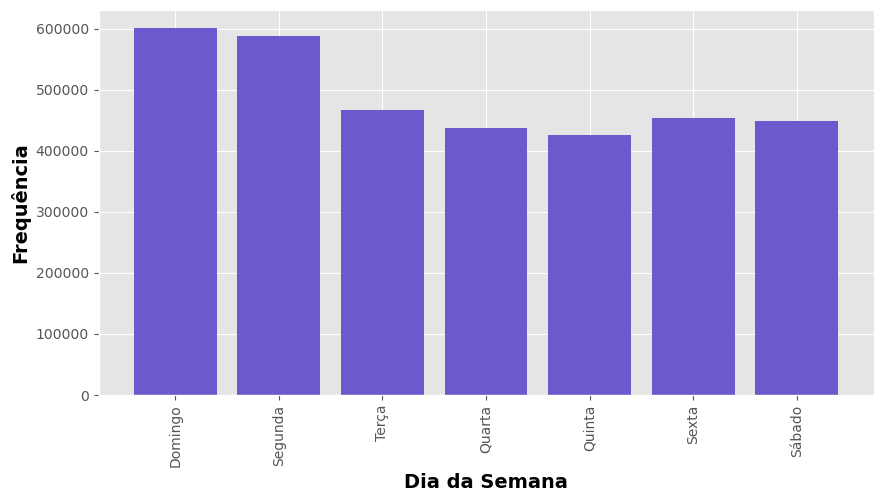

In [33]:
# Plotando em um gráfico
plt.figure(figsize = (10,5))
plt.bar(x,y, color = 'slateblue')
plt.xlabel('Dia da Semana', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xticks(x,['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado'], rotation = 'vertical')
plt.show()

### 3- Qual Hora do Dia Tem o Maior Número de Pedidos?

In [34]:
# Frequências de pedidos pela hora do dia
x = list(range(0,24))
y = []
# Fazendo meu loop 
for i in range(24):
    y.append(order[order['order_hour_of_day']==i].shape[0])

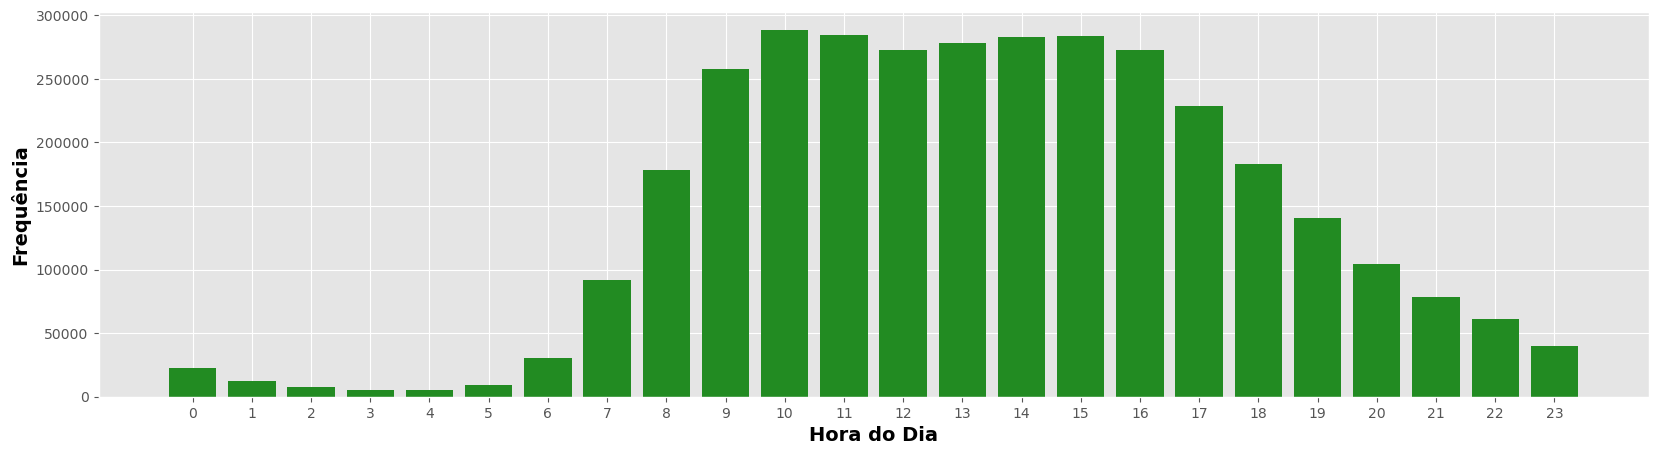

In [35]:
# Fazendo a plotagem 
plt.figure(figsize = (20,5))
plt.bar(x,y,color = 'forestgreen')
plt.xticks(np.arange(0,24,1))
plt.xlabel('Hora do Dia', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 4- Qual Departamento Tem o Maior Número de Pedidos?

In [36]:
# Verificando a  frequencia para cada valor distinto 
dept_cnt = order_product_prior['department'].value_counts()
dept_cnt 

produce            9479291
dairy eggs         5414016
snacks             2887550
beverages          2690129
frozen             2236432
pantry             1875577
bakery             1176787
canned goods       1068058
deli               1051249
dry goods pasta     866627
household           738666
breakfast           709569
meat seafood        708931
personal care       447123
babies              423802
international       269253
alcohol             153696
pets                 97724
missing              69145
other                36291
bulk                 34573
Name: department, dtype: int64

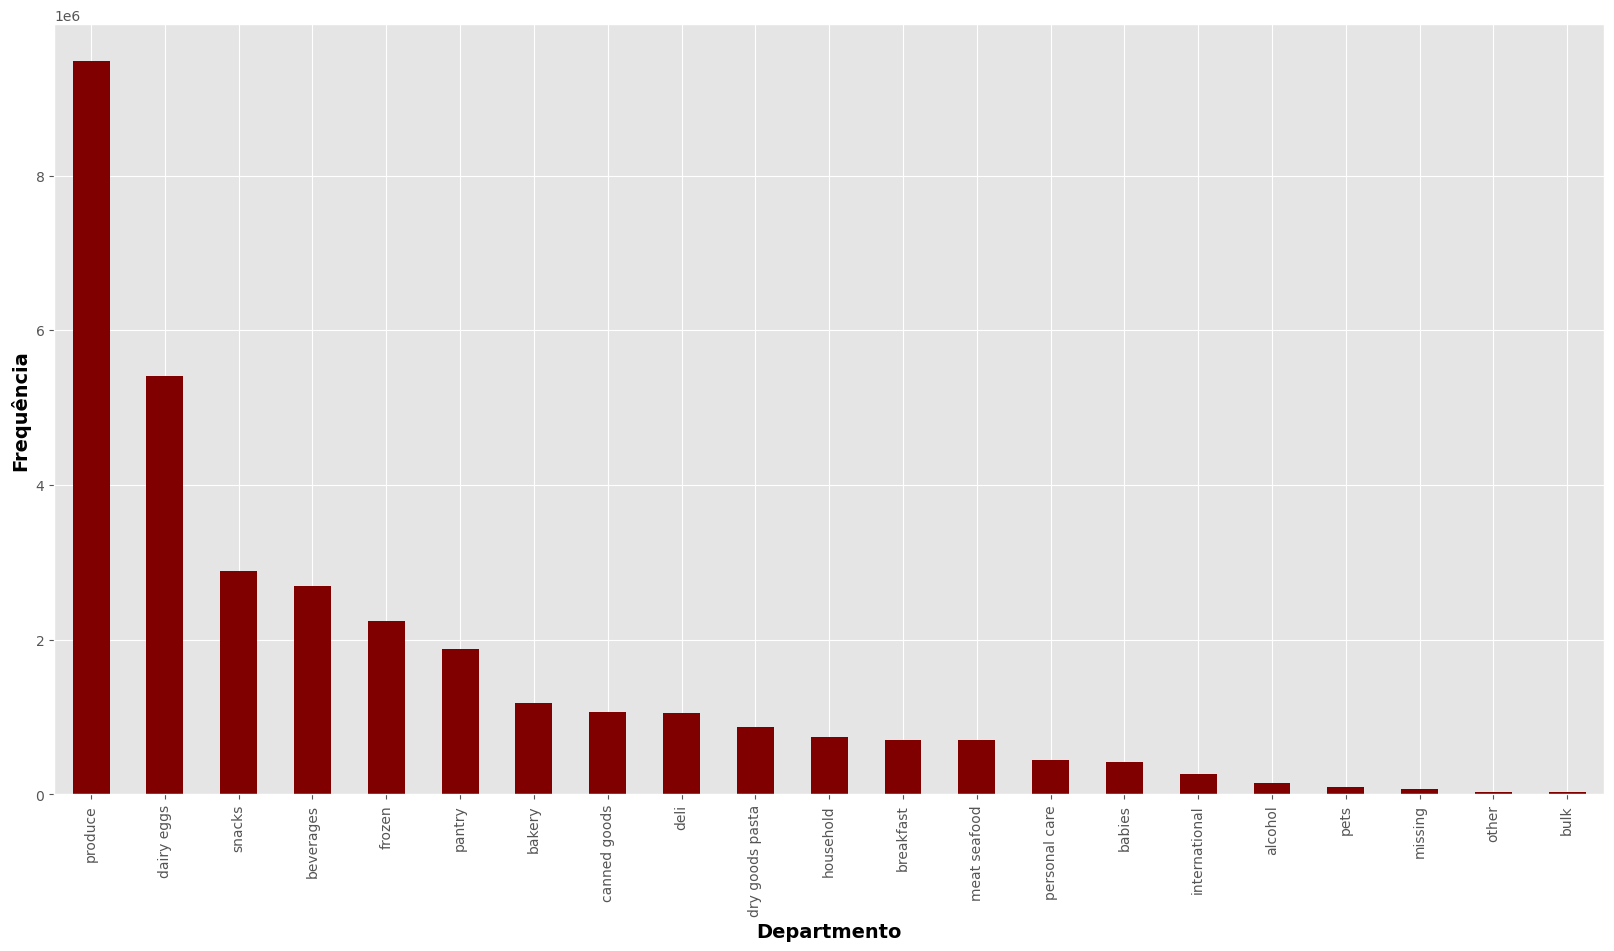

In [37]:
# Faendo a plotagem
fig = plt.figure(figsize = (20,10))
dept_cnt.plot(kind = "bar", color = 'maroon')
plt.xticks(rotation = 90)
plt.xlabel('Departmento', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 5- Quais os 20 Principais Corredores Por Frequência de Pedidos?

In [38]:
# Verificando a frequencia para cada valor distinto 
aisle_cnt = order_product_prior['aisle'].value_counts()

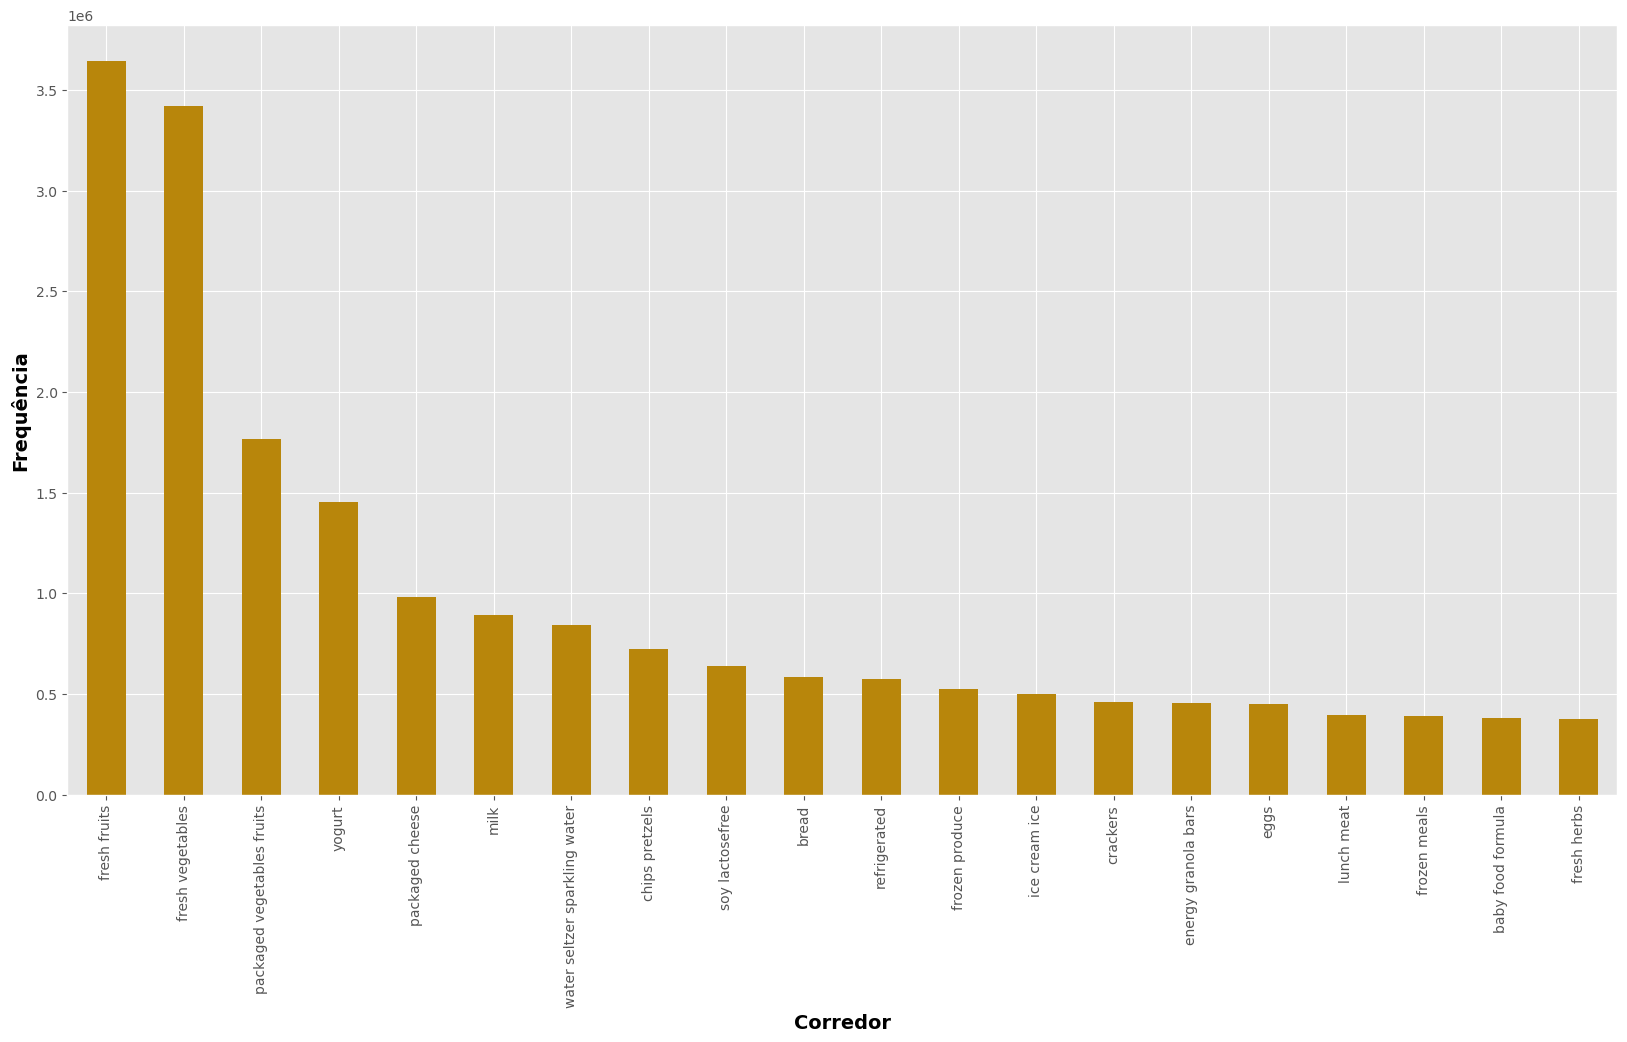

In [39]:
# Fazendo a plotagem 
fig = plt.figure(figsize = (20,10))
aisle_cnt[0:20].plot(kind = "bar", color = 'darkgoldenrod')
plt.xticks(rotation = 90)
plt.xlabel('Corredor', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 6- Quais os 20 Principais Produtos Por Frequência de Pedidos?

In [40]:
# Verificando a frequencia para cada valor unico 
prod_cnt = order_product_prior['product_name'].value_counts()

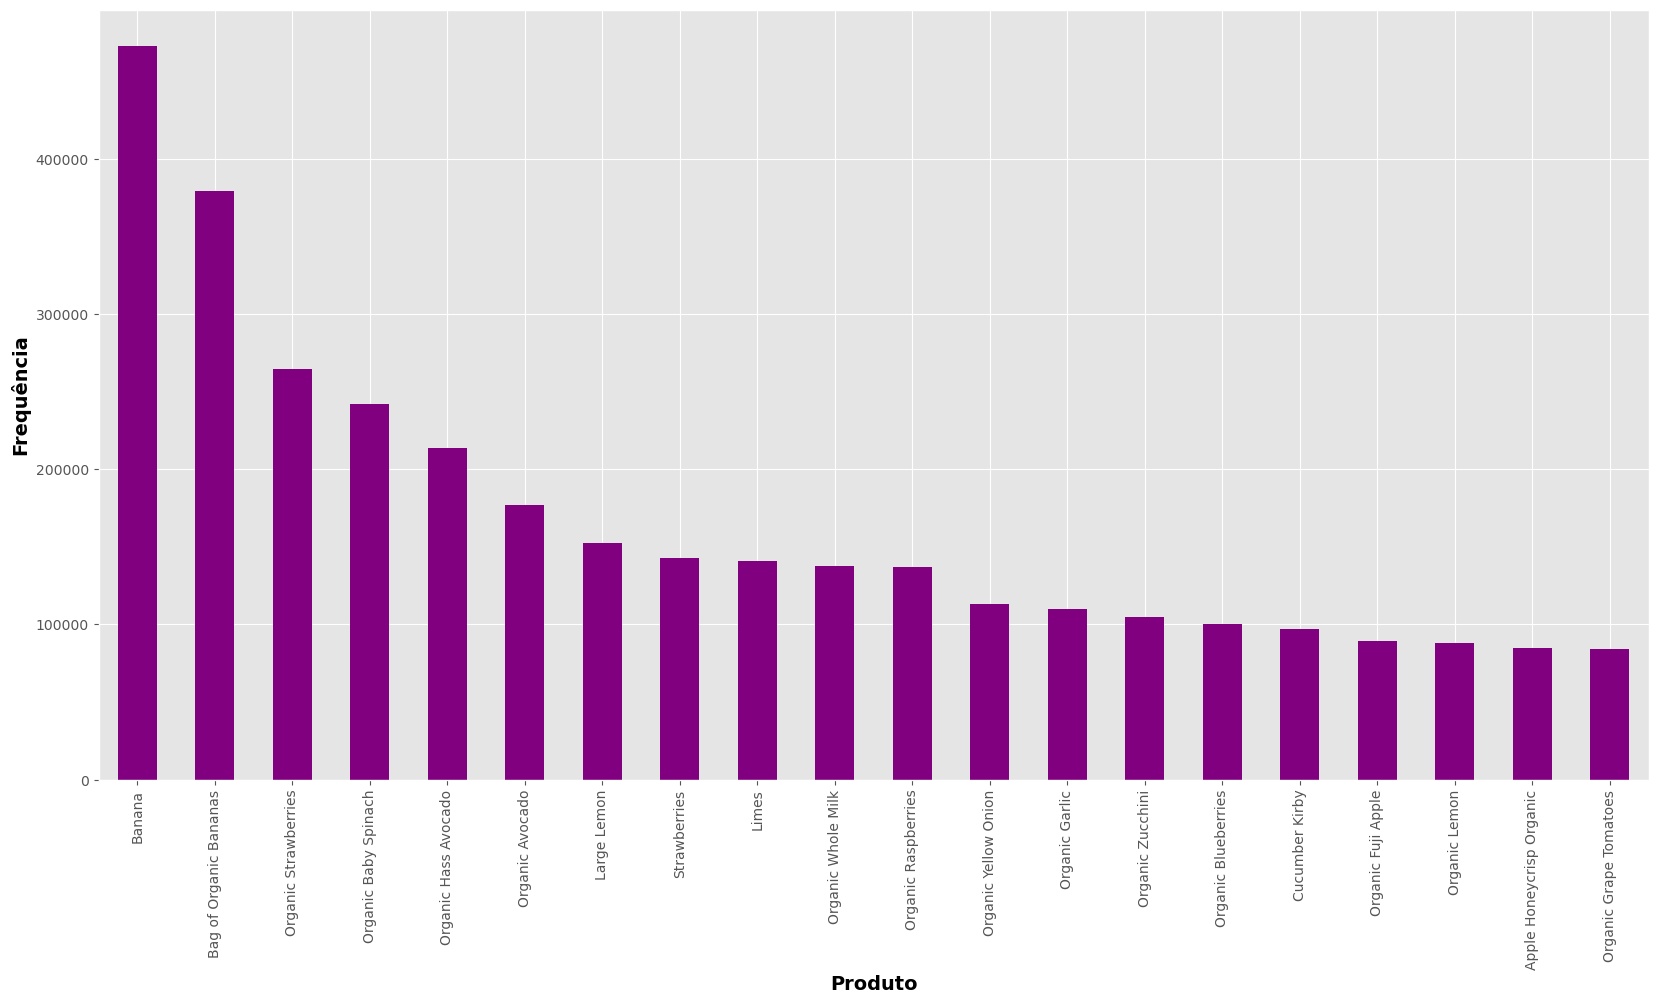

In [41]:
# Fazendo a Plotagem
fig = plt.figure(figsize = (20,10))
prod_cnt[0:20].plot(kind = "bar", color = 'purple')
plt.xticks(rotation = 90)
plt.xlabel('Produto', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 7- Análise de Novos Pedidos Semelhantes a Pedidos Anteriores (reorder)

In [42]:
# Fazendo o agrupamento e a agregação 
temp_df = order_product_prior.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()


In [43]:
# Fazendo a lista
labels = list(temp_df.product_name[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])    

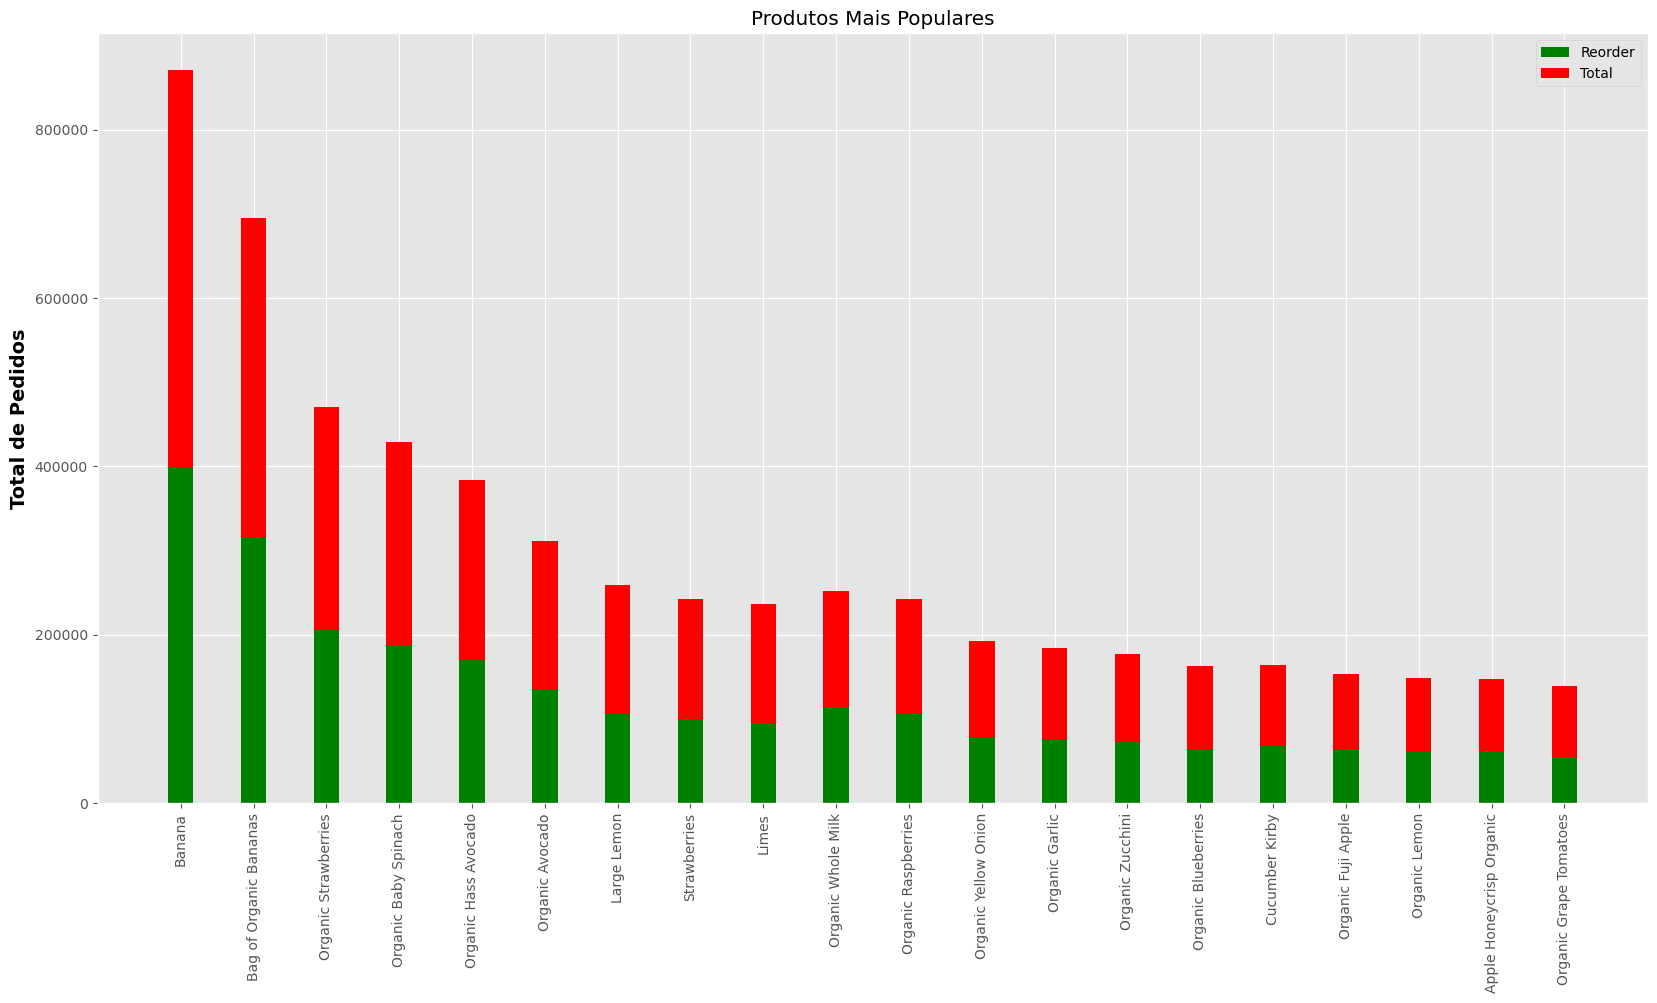

In [44]:
# Fazendo a plotagem 
width = 0.35 
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Produtos Mais Populares")
plt.xticks(rotation = 90)
plt.show()

Verificamos que a proporção e muito semelhante ( os usuarios repetem as compras )

As pessoas voltam para comprar os mesmo produtos tempo depois

### 8- Análise de Reorder Por Departamento ao Longo do Tempo

In [45]:
# Fazendo o agrupamento e a agregação  
grouped_df = order_product_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()
grouped_df.head()

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922


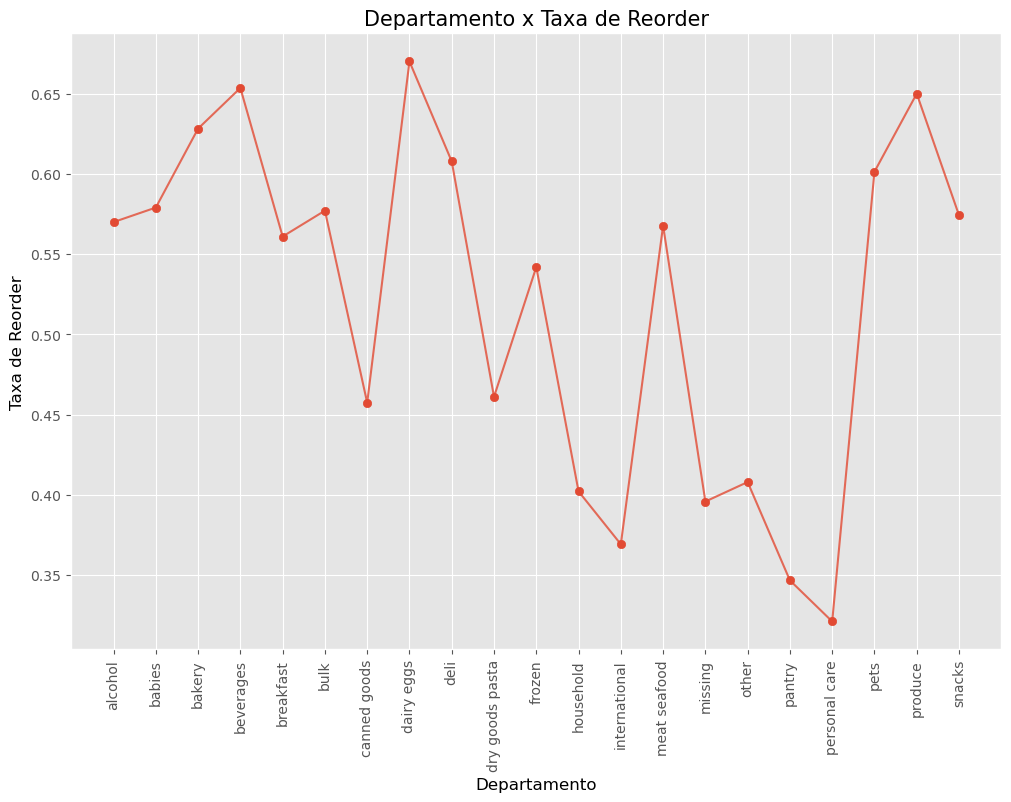

In [46]:
# Fazendo a plotagem 
plt.figure(figsize = (12,8))
plt.plot(list(grouped_df['department']), grouped_df['reordered'].values, alpha=0.8)
plt.scatter(list(grouped_df['department']), grouped_df['reordered'].values)
plt.ylabel('Taxa de Reorder', fontsize = 12)
plt.xlabel('Departamento', fontsize = 12)
plt.title("Departamento x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

Neste gráfico podemos ver qual departamento tem uma repetição de pedidos maior (frequencia maior de pedidos)

Com essa informação o gestor ou diretor pode ter um planejamneto de estoque muito maior

### 9- Análise de Reorder e Pedidos

In [47]:
# Fazendo o agrupamento e agregação
temp_df = order_product_prior.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

In [48]:
# Preparando minha lista para pegar os 20 primeiros
labels = list(temp_df.department[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])

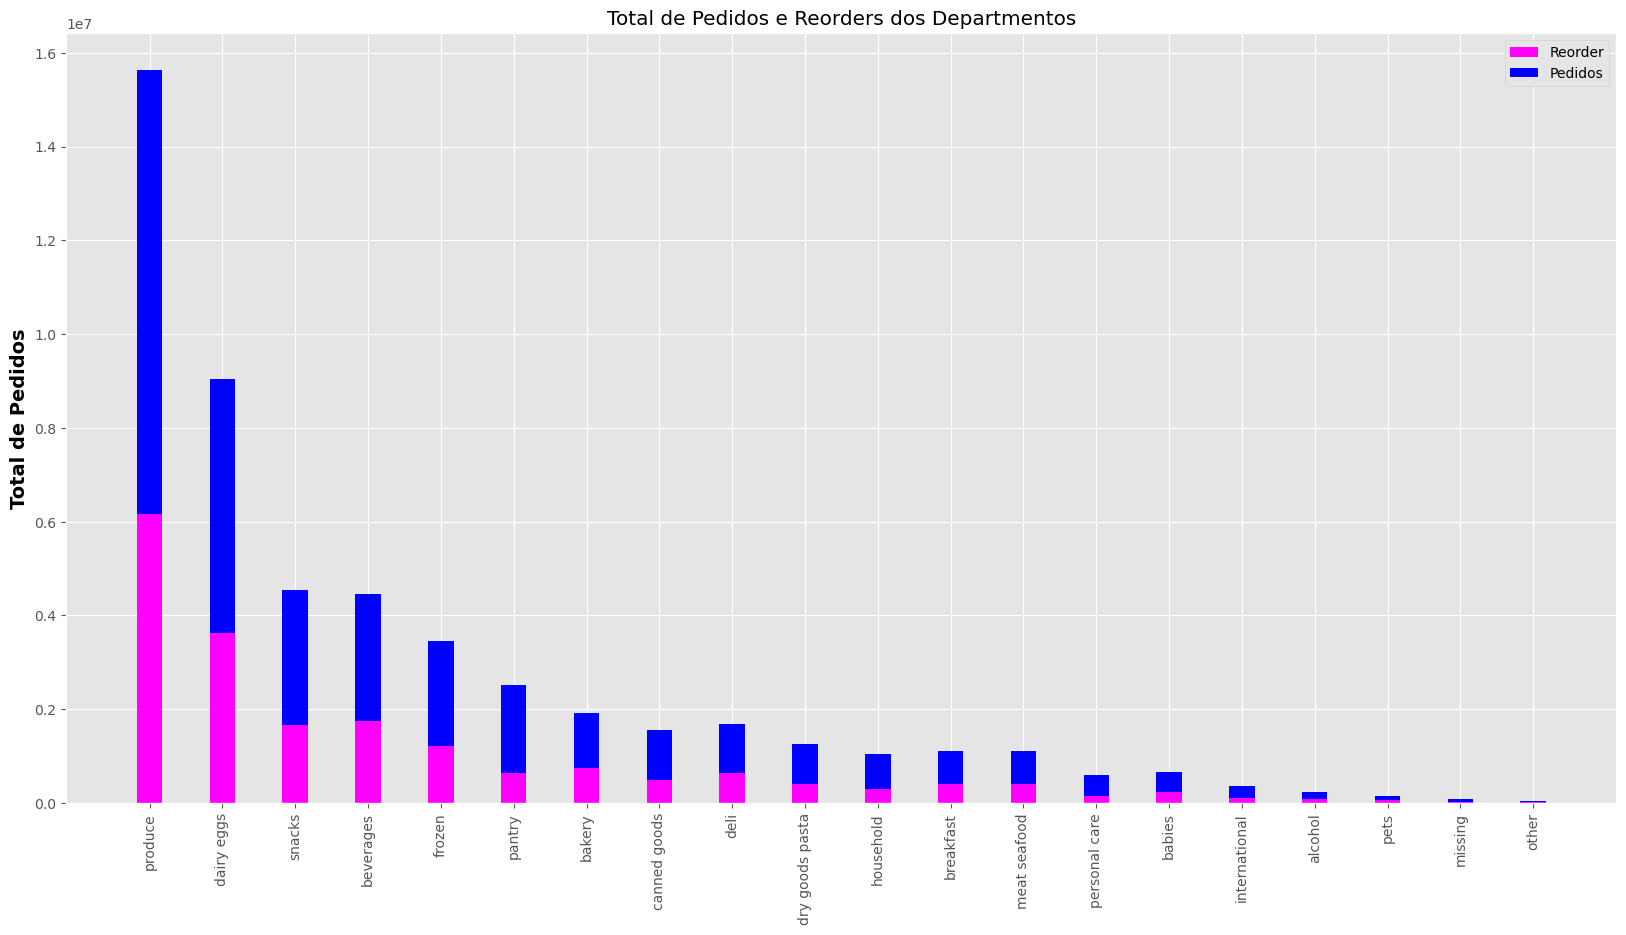

In [49]:
# Fazendo plotagem
width = 0.35  
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'magenta')
ax.bar(labels, total, width, bottom = reorder, label = 'Pedidos', color = 'blue')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Departmentos")
plt.xticks(rotation = 90)
plt.show()

### 9- Análise de Reorder Por Corredor

In [50]:
# Fazendo o agrupamento e agregação com a media
grouped_df = order_product_prior.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()
# Verificando uma amostra 
grouped_df.head()

,aisle,reordered
0,air fresheners candles,0.309052
1,asian foods,0.351132
2,baby accessories,0.550980
3,baby bath body care,0.295770
4,baby food formula,0.590259


In [51]:
# Fazendo uma lista para pegar os 20 primeiros
list(grouped_df['aisle'])[0:20]

['air fresheners candles',
 'asian foods',
 'baby accessories',
 'baby bath body care',
 'baby food formula',
 'bakery desserts',
 'baking ingredients',
 'baking supplies decor',
 'beauty',
 'beers coolers',
 'body lotions soap',
 'bread',
 'breakfast bakery',
 'breakfast bars pastries',
 'bulk dried fruits vegetables',
 'bulk grains rice dried goods',
 'buns rolls',
 'butter',
 'candy chocolate',
 'canned fruit applesauce']

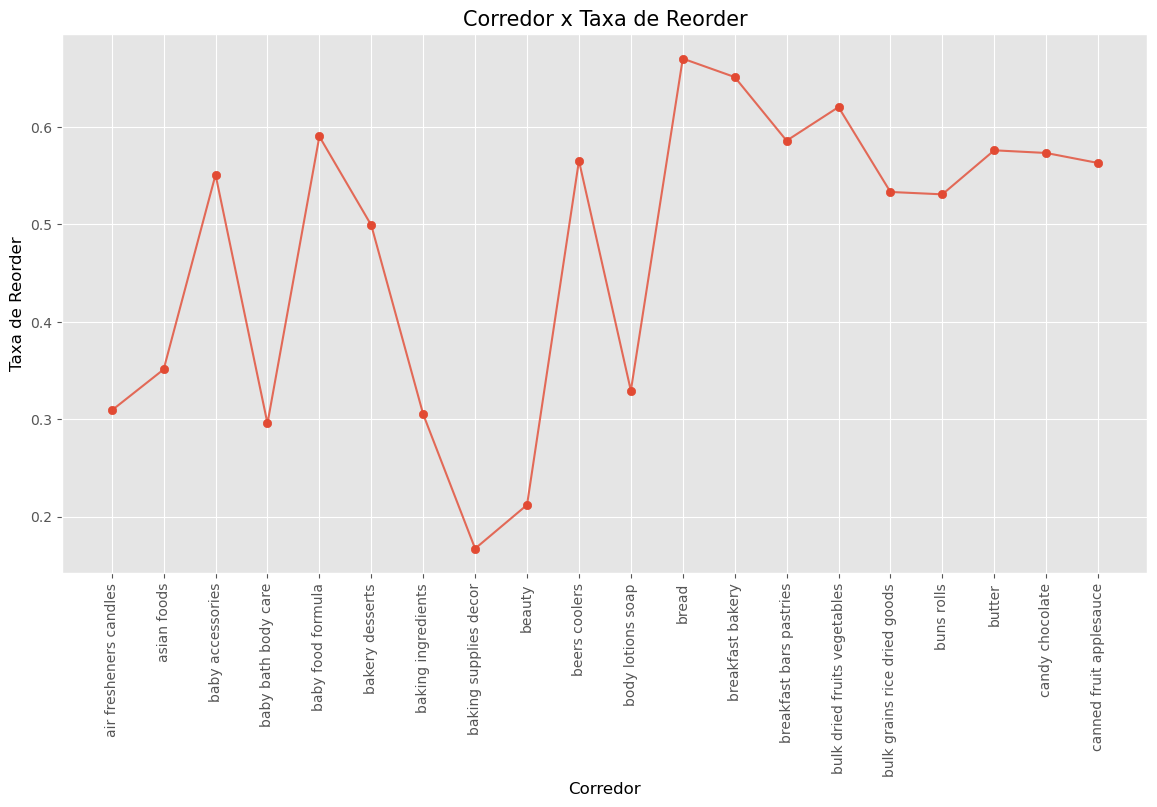

In [52]:
# Fazendo uma plotagem 
plt.figure(figsize=(14,7))
plt.plot(list(grouped_df['aisle'])[0:20], grouped_df['reordered'].values[0:20], alpha=0.8)
plt.scatter(list(grouped_df['aisle'])[0:20], grouped_df['reordered'].values[0:20])
plt.ylabel('Taxa de Reorder', fontsize=12)
plt.xlabel('Corredor', fontsize=12)
plt.title("Corredor x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

### 10- Análise de Reorder Por Corredor (Total)

In [53]:
# Fazendo o agrupamento e agregação com o total 
temp_df = order_product_prior.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()
# Verificando uma amostra 
temp_df.head()

,aisle,total,reorders
0,fresh fruits,3642188,2615469
1,fresh vegetables,3418021,2032172
2,packaged vegetables fruits,1765313,1127177
3,yogurt,1452343,997018
4,packaged cheese,979763,573383


In [54]:
# Fazendo uma lista para pegar os 20 primeiros
labels = list(temp_df.aisle[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])

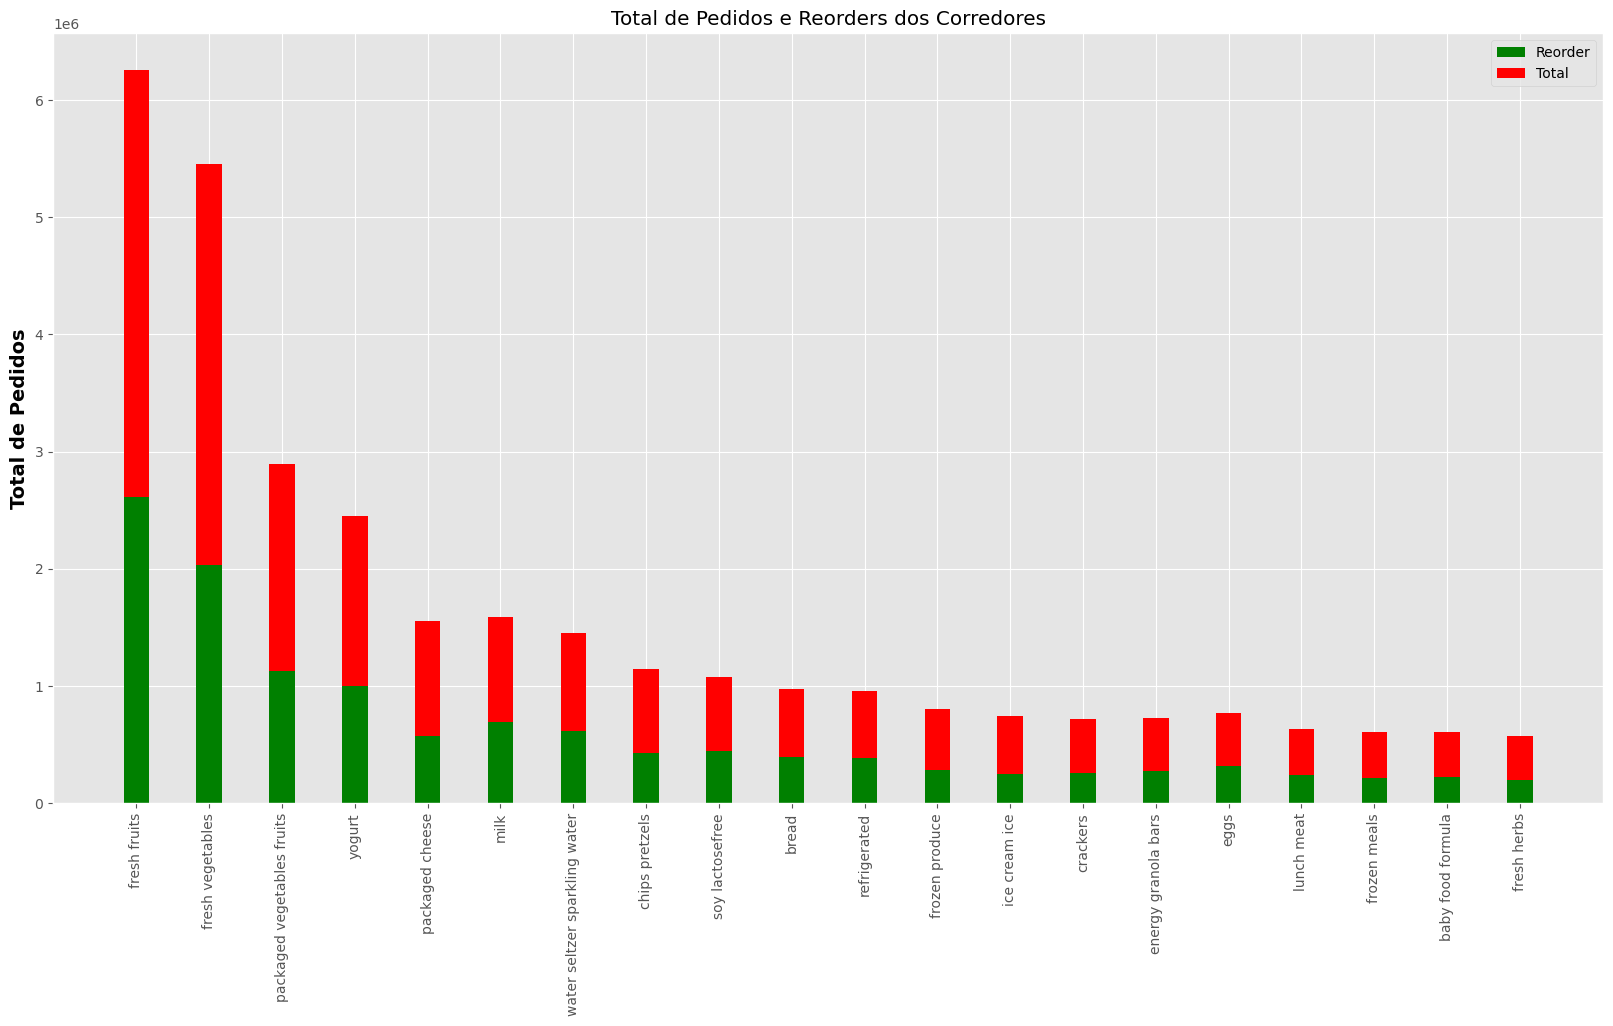

In [55]:
# fazendo uma Plotagem
width = 0.35      
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Corredores")
plt.xticks(rotation = 90)
plt.show()

### <font color='blue'>Implementando o algoritmo</font>

Através dessas análises, podemos verificar que existe um PADRÃO. E isto é FUNDAMENTAL.

Não posso seguir adiante com nenhum algoritmo, seja de Machine Learning, ou de mineração de dados, antes de detectar um Padrão.Visto que nenhum algoritmo cria um padrão, só detecta 

O que o algoritmo apriori irá fazer é detectar o padrão e criar regras de associações dos produtos


O algoritmo usa 3 métricas genéricas para sua criação

Se os valores das métricas forem muito baixo, será extraido muitas regras de associações,provalvemente regaras fracas

Se os valores das métricas forem altas,será extraido poucas regras de associações, provalvemente regras fortes

![title](imagens/regras.png)

Support = Fração de transações que contêm A e B.

![title](imagens/support.png)

Confidence = A frequência com que B aparece em transações que contêm apenas A.

![title](imagens/confidence.png)

Lift = Quanto aumentou nossa confiança de que B será comprado, dado que A foi comprado.

![title](imagens/lift.png)

In [56]:
# Preparando a tupla com as transações
transactions_tup = [tuple(row) for row in transactions['Products'].tolist()]

### <font color='blue'>Criando um Ambiente de Teste</font>

#### Executa o Algoritmo Apriori Com Support = 0.01 e Confidence = 0.2

In [59]:
# Filtrando os 50000 da tabela transactions
itemsets_ap, rules_ap = apriori(transactions_tup[:500000], min_support = 0.01, min_confidence = 0.2)

In [60]:
# Visualizando as regras de associações
rules_ap 

[{21137} -> {13176},
 {21903} -> {13176},
 {27966} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {21903} -> {24852},
 {28204} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852}]

In [61]:
# Listas de itens para considerar
item_A = [27966,47209,21137,47766,21903,49683,47626,28204,16797,21903,21137,27966]
item_B = [13176,13176,24852,24852,24852,24852,24852,24852,24852,13176,13176,21137]
temp = pd.DataFrame()
temp['itemA'] = item_A
temp['itemB'] = item_B

In [62]:
# Listas para as métricas
support_A = []
support_B = []
support_AB = []
confidence_AB = []
lift_AB = []

In [63]:
# Loop
for i in range(len(temp)):
    
    # Calcula o support de A
    support_A.append(itemsets_ap[1][tuple([temp['itemA'][i],])] / 500000)
    
    # Calcula o support de B
    support_B.append(itemsets_ap[1][tuple([temp['itemB'][i],])] / 500000)
    
    # Calcula o support de A e B
    if tuple([temp['itemA'][i],temp['itemB'][i]]) in itemsets_ap[2].keys():
        support_AB.append(itemsets_ap[2][tuple([temp['itemA'][i],temp['itemB'][i]])] / 500000)
    else:
        support_AB.append(itemsets_ap[2][tuple([temp['itemB'][i],temp['itemA'][i]])] / 500000)
    
    # Calcula a confidence
    confidence_AB.append(support_AB[i] / support_A[i])
    
    # Calcula o lift
    lift_AB.append(support_AB[i] / (support_A[i] * support_B[i]))

In [64]:
# Dataframe com as regras de associação
df_rules_ap = pd.DataFrame()
df_rules_ap['product_id'] = item_A
df_rules_ap = df_rules_ap.merge(product, on = 'product_id', how = 'left')
df_rules_ap['Product_A'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['product_id'] = item_B
df_rules_ap = df_rules_ap.merge(product, on = 'product_id', how = 'left')
df_rules_ap['Product_B'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['Support_A'] = support_A
df_rules_ap['Support_B'] = support_B
df_rules_ap['Support_AB'] = support_AB
df_rules_ap['Confidence_AB'] = confidence_AB
df_rules_ap['Lift_AB'] = lift_AB

In [65]:
df_rules_ap.sort_values(by = 'Confidence_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
4,Organic Baby Spinach,Banana,0.075000,0.147194,0.016016,0.213547,1.450784


In [66]:
df_rules_ap.sort_values(by = 'Lift_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
9,Organic Baby Spinach,Bag of Organic Bananas,0.075000,0.117802,0.015500,0.206667,1.754356


A partir daí, podemos observar que quem compra o PRODUTO A , tambem compra o PRODUTO B

Seguindo as métricas utilizada

#### Executa o Algoritmo Apriori Com Support = 0.005 e Confidence = 0.2¶

In [68]:
itemsets_ap_1, rules_ap_1 = apriori(transactions_tup[:500000], min_support = 0.005, min_confidence = 0.2)

In [69]:
rules_ap_1

[{4605} -> {24852},
 {4920} -> {24852},
 {5876} -> {13176},
 {5876} -> {47209},
 {8277} -> {13176},
 {8277} -> {24852},
 {9076} -> {24852},
 {19057} -> {13176},
 {21137} -> {13176},
 {21903} -> {13176},
 {22935} -> {13176},
 {27966} -> {13176},
 {30391} -> {13176},
 {37646} -> {13176},
 {39275} -> {13176},
 {45007} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {30391} -> {21137},
 {39275} -> {21137},
 {21903} -> {24852},
 {24964} -> {22935},
 {26209} -> {24852},
 {27845} -> {24852},
 {28204} -> {24852},
 {30489} -> {24852},
 {37646} -> {24852},
 {40706} -> {24852},
 {42265} -> {24852},
 {44632} -> {24852},
 {45066} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852},
 {31717} -> {26209},
 {30391} -> {47209}]

In [70]:
# Lista de itens para considerar
item_A1 = [27966,47209,4605,21137,47766,21903,49683,5876,37646,40706,47626,5876,30391,22935,37646,31717,
           28204,27845,24964,45066,9076,16797,21903,8277,30391,21137,27966,19057,26209,45007,39275,30489,
           42265,30391,8277,4920,39275,44632]
item_B1 = [13176,13176,24852,24852,24852,24852,24852,47209,24852,24852,24852,13176,13176,13176,13176,26209,
           24852,24852,22935,24852,24852,24852,13176,24852,47209,13176,21137,13176,24852,13176,21137,24852,
           24852,21137,13176,24852,13176,24852]
temp1 = pd.DataFrame()
temp1['itemA'] = item_A1
temp1['itemB'] = item_B1

In [71]:
# Listas de métricas
support_A1 = []
support_B1 = []
support_AB1 = []
confidence_AB1 = []
lift_AB1 = []

In [72]:
# Loop
for i in range(len(temp1)):
    
    support_A1.append(itemsets_ap_1[1][tuple([temp1['itemA'][i],])] / 500000)
    
    support_B1.append(itemsets_ap_1[1][tuple([temp1['itemB'][i],])] / 500000)
    
    if tuple([temp1['itemA'][i],temp1['itemB'][i]]) in itemsets_ap_1[2].keys():
        support_AB1.append(itemsets_ap_1[2][tuple([temp1['itemA'][i],temp1['itemB'][i]])] / 500000)
    else:
        support_AB1.append(itemsets_ap_1[2][tuple([temp1['itemB'][i],temp1['itemA'][i]])] / 500000)
    
    confidence_AB1.append(support_AB1[i] / support_A1[i])
    
    lift_AB1.append(support_AB1[i] / (support_A1[i] * support_B1[i]))

In [73]:
# Dataframe com as regras de associação
df_rules_ap1 = pd.DataFrame()
df_rules_ap1['product_id'] = item_A1
df_rules_ap1 = df_rules_ap1.merge(product, on = 'product_id', how = 'left')
df_rules_ap1['Product_A'] = df_rules_ap1['product_name']
df_rules_ap1 = df_rules_ap1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap1['product_id'] = item_B1
df_rules_ap1 = df_rules_ap1.merge(product, on = 'product_id', how = 'left')
df_rules_ap1['Product_B'] = df_rules_ap1['product_name']
df_rules_ap1 = df_rules_ap1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap1['Support_A'] = support_A1
df_rules_ap1['Support_B'] = support_B1
df_rules_ap1['Support_AB'] = support_AB1
df_rules_ap1['Confidence_AB'] = confidence_AB1
df_rules_ap1['Lift_AB'] = lift_AB1

In [74]:
# Visualizando nosso dataframe ordenado pelo "Confidence_AB"
df_rules_ap1.sort_values(by = 'Confidence_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
16,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
19,Honeycrisp Apple,Banana,0.024774,0.147194,0.008832,0.356503,2.421993
6,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
4,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
35,Seedless Red Grapes,Banana,0.026054,0.147194,0.007750,0.297459,2.020864
2,Yellow Onions,Banana,0.022814,0.147194,0.006750,0.295871,2.010075
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
20,Blueberries,Banana,0.017674,0.147194,0.005186,0.293425,1.993460
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037


In [75]:
# Visualizando nosso dataframe ordenado pelo "Lift_AB"
df_rules_ap1.sort_values(by = 'Lift_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
15,Organic Cilantro,Limes,0.021334,0.043640,0.005342,0.250398,5.737819
18,Organic Garlic,Organic Yellow Onion,0.034158,0.035306,0.006868,0.201066,5.694942
7,Organic Lemon,Organic Hass Avocado,0.027242,0.066218,0.006534,0.239850,3.622130
24,Organic Cucumber,Organic Hass Avocado,0.025056,0.066218,0.005396,0.215358,3.252252
26,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
30,Organic Blueberries,Organic Strawberries,0.031188,0.082550,0.007284,0.233551,2.829211
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
16,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
33,Organic Cucumber,Organic Strawberries,0.025056,0.082550,0.005138,0.205061,2.484078


### <font color='blue'>FIM</font>